## Import Libraries

In [1]:
import keras
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers
from keras.callbacks import ModelCheckpoint
import numpy as np
import pickle

#fix random seed for reproducibility
seed = 3
np.random.seed(seed)

Using TensorFlow backend.


## Load train and test data

In [2]:
def get_proper_images(raw):
    raw_float = np.array(raw, dtype='float32') 
    images = raw_float.reshape([-1, 3, 32, 32])
    images = images.transpose([0, 2, 3, 1])
    return images

with open('./train_data', 'rb') as f: 
    train_data = get_proper_images(pickle.load(f)) 
    train_labels = pickle.load(f)
    
with open('./test_data', 'rb') as f:
    test_data = get_proper_images(pickle.load(f))

## Prepare data

In [3]:
mean = np.mean(train_data,axis=(0,1,2,3))
std = np.std(train_data, axis=(0, 1, 2, 3))

train_data = (train_data-mean)/(std+1e-7)
test_data = (test_data-mean)/(std+1e-7)

validation_data = train_data[49000:, :, :, :]
validation_labels = train_labels[49000:]
train_data = train_data[:49000, :, :, :]
train_labels = train_labels[:49000]

print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)
print(train_data.shape[0],'training samples')
print(validation_data.shape[0],'validation samples')
print(test_data.shape[0],'testing samples')

(49000, 32, 32, 3)
(1000, 32, 32, 3)
(10000, 32, 32, 3)
49000 training samples
1000 validation samples
10000 testing samples


## Plot data  

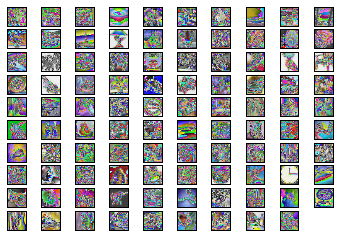

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
fig_size = [10, 10]
plt.rcParams['figure.figsize'] = fig_size

idx = 0
for idx in range(1, 100):
    ax = plt.subplot(10, 10, idx)
    img = test_data[idx, :, :, :]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    plt.imshow(img, cmap="Greys_r")
plt.show()

## Set some parameters

In [ ]:
num_classes = 100
epochs = 250
batch_size = 128


## Preprocess class labels

In [6]:
train_labels = keras.utils.to_categorical(train_labels, num_classes)
validation_labels = keras.utils.to_categorical(validation_labels, num_classes)

## Data augmentation

In [7]:
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
datagen.fit(train_data)

## Define model architecture

In [8]:
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu', 
                 kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
__________

## Compile model

In [9]:
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

## Checkpoint for saving model

In [10]:
# checkpoint
checkpoint = ModelCheckpoint('weightsbest.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

## Train the model

In [ ]:
learning_rate = 0.1
for epoch in range(1, 250):
    if epoch%25==0 and epoch>0:
        learning_rate/=2
        sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    model.fit(train_data, train_labels, batch_size=batch_size,
                                epochs=epoch,
                                validation_data=(validation_data, validation_labels),initial_epoch=epoch-1, callbacks=[checkpoint], shuffle=True)
model.save_weights('final_best_weights.h5')


Train on 49000 samples, validate on 1000 samples
Epoch 1/1


## Classify test data

In [11]:
model.predict(test_data)
predictions = model.predict(test_data)
predictions = np.argmax(predictions, axis=1)
csv_content = np.vstack((np.arange(test_data.shape[0]),predictions)).transpose()
np.savetxt('predictions.csv', csv_content, fmt='%d', delimiter=',', header="ids,labels", comments='')

Prediction finished
Done
